# Classification of Handwritten Digits from the MNIST Database

We will illustrate multiple Machine Learning algorithms by using them for classifying handwritten digits.

# Using Classwise Logistic Regression

Here we perform [logistic regression](http://ufldl.stanford.edu/tutorial/supervised/LogisticRegression/) on each class of digit. For a given digit, then we choose the class with maximum (log) likelihood that the digit belongs to that class. We use stochastic gradient descent to get the values of the regression parameters. 

Note here that these likelihoods are not probabilities that the digit belongs to a particular class (they need not even sum to 1). This is a discriminative algorithm.

The naive implementation of this algorithm is unlikely to give a very good result, as for each class the ratio of members of the class to non-members of the class is 1 : 9 (ie, the data is biased). Therefore, we correct for the bias in the data by taking a 1 : 1 ratio of class members and non-class members during gradient descent. 

In [46]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train_r = np.zeros((x_train.shape[0], 1 + x_train.shape[1]*x_train.shape[2]))

mean = np.mean(x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2]), axis=0)
std_dev = np.std(x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2]), axis=0)

for i in range(std_dev.shape[0]):
    if np.isclose(std_dev[i], 0):
        std_dev[i] = 1 # if STD DEV is close to 0, x - mean will already be close to 0, so we don't normalize

for i in range(x_train_r.shape[0]):
    x_train_r[i] = np.insert((np.reshape(x_train[i], (x_train.shape[1]*x_train.shape[2], )) - mean)/std_dev, 0, 1)

params = np.zeros((10, x_train_r.shape[1]))

def hypothesis(digit, vector):
    return 1/(1 + np.exp(-np.dot(params[digit], vector)))

# Correct for bias in data
num_to_list = {}
for i in range(10):
    num_to_list[i] = []

for i in range(x_train_r.shape[0]):
    num_to_list[y_train[i]].append(i)

for i in range(10):
    num_to_list[i] = np.array(num_to_list[i])

# Our hyperparameters
NUM_ITER = 6000
LEARN_RATE = 1e-2
BATCH_SIZE = 360

def grad_descent(digit, iterations = NUM_ITER, learning_rate = LEARN_RATE):
    for _ in range(iterations):
        sum = np.zeros(x_train_r.shape[1])
        batch = np.concatenate(tuple([np.random.choice(num_to_list[p], int(BATCH_SIZE/2)) if p == digit else np.random.choice(num_to_list[p], int(BATCH_SIZE/18)) for p in range(10)]))

        for i in batch:
            if y_train[i] == digit:
                sum += (1 - hypothesis(digit, x_train_r[i]))*x_train_r[i]
            else:
                sum -= hypothesis(digit, x_train_r[i])*x_train_r[i]
        params[digit] += learning_rate*sum


for i in range(10):
    grad_descent(i)

def prediction(digit):
    r_dig = np.insert((np.reshape(digit, (x_train.shape[1]*x_train.shape[2], )) - mean)/std_dev, 0, 1)
    return np.argmax([hypothesis(i, r_dig) for i in range(10)])

num_occ = 0
for i in range(x_test.shape[0]):
    if prediction(x_test[i]) == y_test[i]:
        num_occ += 1

print(f'Accuracy: {num_occ*100/x_test.shape[0]}%')

/tmp/ipykernel_268/915958806.py:22: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-np.dot(params[digit], vector)))


Accuracy: 88.54%


Predicted: 4
Actual: 4


/tmp/ipykernel_7009/3849353442.py:15: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-np.dot(params[digit], vector)))


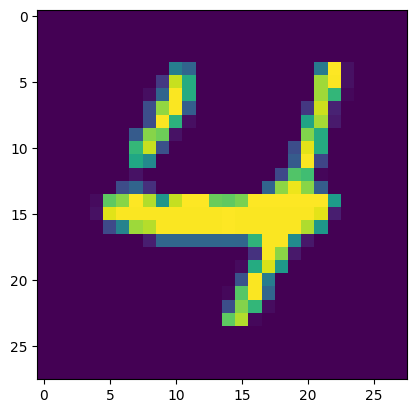

In [7]:
i = np.random.randint(0, x_test.shape[0])
plt.imshow(x_test[i]);
print(f'Predicted: {prediction(x_test[i])}')
print(f'Actual: {y_test[i]}')

With ```6000``` iterations of gradient descent, a learning rate of ```0.01``` and a minibatch size of ```180```, we get an accuracy of ```88.54%```.

## Using Softmax Regression

[This](http://deeplearning.stanford.edu/tutorial/supervised/SoftmaxRegression/) is more appropriate for multiclass classification than plain logistic regression. Here the probabilities of a digit belonging to a class are drawn from a multivariate Bernoulli distribution, on which we perform maximum likelihood estimation via stochastic gradient descent. 

This is also a discriminative model.

In [52]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train_r = np.zeros((x_train.shape[0], 1 + x_train.shape[1]*x_train.shape[2]))

mean = np.mean(x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2]), axis=0)
std_dev = np.std(x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2]), axis=0)

for i in range(std_dev.shape[0]):
    if np.isclose(std_dev[i], 0):
        std_dev[i] = 1 # if STD DEV is close to 0, x - mean will already be close to 0, so we don't normalize

for i in range(x_train_r.shape[0]):
    x_train_r[i] = np.insert((np.reshape(x_train[i], (x_train.shape[1]*x_train.shape[2], )) - mean)/std_dev, 0, 1)

params = np.zeros((x_train_r.shape[1], 9))

def sstat(digit):
    arr = np.zeros(9)
    if digit < 9:
        arr[digit] = 1
    return arr

def hypothesis(vector):
    arr = np.matmul(np.transpose(params), vector)
    narr = np.zeros(9)
    for i in range(9):
        sum = np.exp(-arr[i])
        for j in range(9):
            sum += np.exp(arr[j] - arr[i])
        narr[i] = 1/sum
    return narr

# Our hyperparameters for gradient descent
NUM_ITER = 8000
LEARN_RATE = 1e-2
BATCH_SIZE = 500

for _ in range(NUM_ITER):
    sum = np.zeros((x_train_r.shape[1], 9))
    batch = np.random.choice(range(x_train_r.shape[0]), BATCH_SIZE)
    for i in batch:
        sum += np.outer(x_train_r[i], sstat(y_train[i]) - hypothesis(x_train_r[i]))
    params += LEARN_RATE*sum

def prediction(img):
    dig = np.insert((img.reshape(x_train.shape[1]*x_train.shape[2]) - mean)/std_dev, 0, 1)
    hyp = hypothesis(dig)
    hyp = np.append(hyp, 1 - np.sum(hyp))
    return np.argmax(hyp)

num_occ = 0
for i in range(x_test.shape[0]):
    if prediction(x_test[i]) == y_test[i]:
        num_occ += 1

print(f'Accuracy: {num_occ*100/x_test.shape[0]}%')

/tmp/ipykernel_268/615135398.py:32: RuntimeWarning: overflow encountered in exp
  sum += np.exp(arr[j] - arr[i])
/tmp/ipykernel_268/615135398.py:30: RuntimeWarning: overflow encountered in exp
  sum = np.exp(-arr[i])


Accuracy: 90.13%


Predicted: 3
Actual: 3


/tmp/ipykernel_268/3308815789.py:23: RuntimeWarning: overflow encountered in exp
  sum = np.exp(-arr[i])
/tmp/ipykernel_268/3308815789.py:25: RuntimeWarning: overflow encountered in exp
  sum += np.exp(arr[j] - arr[i])


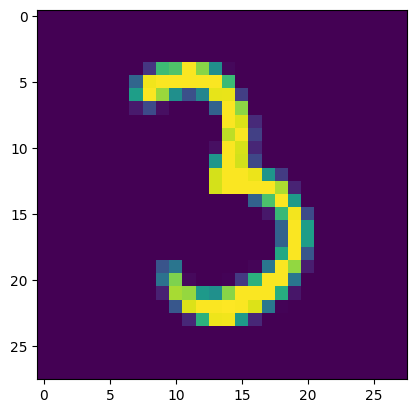

In [12]:
i = np.random.randint(0, x_test.shape[0])
plt.imshow(x_test[i]);
print(f'Predicted: {prediction(x_test[i])}')
print(f'Actual: {y_test[i]}')

With ```8000``` iterations of gradient descent, a learning rate of ```0.01``` and a minibatch size of ```500```, we get an accuracy of ```90.13%```.

## Gaussian Discriminant Analysis

We assume each class of digit is distributed according to some Multivariate Gaussian whose mean and covariance we calculate (using the sample mean and sample covariance of each digit). Have a look at the slides on Multivariate Gaussian for an overview.

To classify a digit then, we choose the class such that the probability that the digit belongs to the class is maximum. We calculate this probability using Baye's Theorem ( $P(y | x) = \frac{P(x | y)P(y)}{P(x)}$ ). This is an example of a generative learning model.

However, while calculating the sample covariance, it will come out to be singular or almost singular, as there are a large number of principal components with eigenvalues close to 0 (or 0). Therefore, we must reduce the dimensionality of the data by projecting it onto the space spanned by the first few principal components. Note that since we're already calculating the principal components here, there is no need to normalize the data.

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

NUM_PRINC = 150 # Number of Principal Components (our hyperparameter)

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train_r = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2]).astype('float64')

num_to_list = {}

for i in range(10):
    num_to_list[i] = []

for i in range(x_train_r.shape[0]):
    num_to_list[y_train[i]].append(x_train_r[i])

for i in range(10):
    num_to_list[i] = np.array(num_to_list[i])

means = np.array([np.mean(num_to_list[i], axis=0) for i in range(10)])
covariances = np.array([np.cov(num_to_list[i].T, bias=True) for i in range(10)])

princ_comps = np.zeros((10, NUM_PRINC, x_train_r.shape[1]))
eigen_vals = np.zeros((10, NUM_PRINC))


for i in range(10):
    x, y = np.linalg.eigh(covariances[i])
    eigen_vals[i] = x[x.size - NUM_PRINC:][::-1]
    for j in range(NUM_PRINC):
        princ_comps[i][j] = y[: , y.shape[1] - j - 1]

def projection(num, vector):
    return np.array([np.dot(x, vector) for x in princ_comps[num]])

log_determinants = np.array([np.sum(np.log(eigen_vals[i])) for i in range(10)])
proj_means = np.array([projection(i, means[i]) for i in range(10)])


def neg_log_prob(num, vector):
    wrt_mean = projection(num, vector) - proj_means[num]
    return log_determinants[num] + np.sum([(wrt_mean[i] ** 2)/eigen_vals[num][i] for i in range(NUM_PRINC)]) + np.log(x_train_r.shape[0]/num_to_list[num].shape[0])

def prediction(digit):
    digit = digit.reshape(x_train_r.shape[1]).astype('float64')
    return np.argmin(np.array([neg_log_prob(i, digit) for i in range(10)]))

num_occ = 0
for i in range(x_test.shape[0]):
    if prediction(x_test[i]) == y_test[i]:
        num_occ += 1

print(f'Accuracy: {num_occ*100/x_test.shape[0]}%')

Accuracy: 95.59%


Predicted: 6
Actual: 6


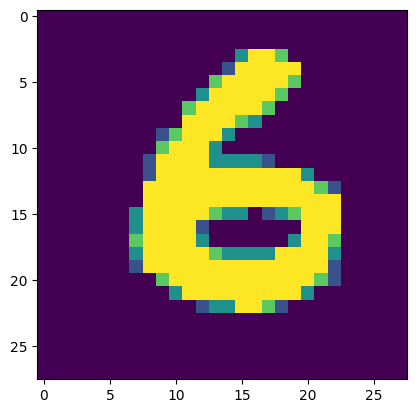

In [44]:
i = np.random.randint(0, x_test.shape[0])
plt.imshow(x_test[i]);
print(f'Predicted: {prediction(x_test[i])}')
print(f'Actual: {y_test[i]}')

### Hyperparameter Tuning
The hyperparameter here is the number of principal components considered. We choose the number that maximizes the accuracy on testing.

| Number of Principal Components           | Accuracy               |
| ---------------------------------------- | -----------------------|
| ```1```                                  | ```4.55%```            |
| ```80```                                 | ```94.24%```           |
| ```150```                                | ```95.59%```           |
| ```240```                                | ```94.78%```           |
| ```320```                                | ```93.72%```           |
| ```400```                                | ```91.45%```           |
| ```480```                                | ```87.61%```           |
| ```560```                                | ```65.83%```           |
| ```640```                                | ```9.8%```             |
| ```720```                                | ```9.8%```             |
| ```784```                                | ```9.8%```             |


# Using Support Vector Machines

Here we make ${10\choose 2} = 45$ support vector machines that can distinguish every pair of classes. We will use Linear and RBF/Gaussian Kernels for the support vector machines and use the [SMO Algorithm](https://web.iitd.ac.in/~sumeet/tr-98-14.pdf), discovered by John C Platt for optimization. This is much faster than Gradient Descent would be, as it makes use of the fact that the dual problem of the SVM is a Quadratic Optimization Problem.

The support vector machine is another discriminative algorithm, but this one can identify non-linear decision boundaries as well.

For a given image, we will map it to the digit to which it is classified the most (on average, the image will be mapped to the correct digit $\frac{9}{4}$ times more than the other digits).

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib as plt

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

mean = np.mean(x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2]), axis=0)
std_dev = np.std(x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2]), axis=0)

for i in range(std_dev.shape[0]):
    if np.isclose(std_dev[i], 0):
        std_dev[i] = 1 # if STD DEV is close to 0, x - mean will already be close to 0, so we don't normalize

num_to_list = {}
for i in range(10):
    num_to_list[i] = []

for i in range(x_train.shape[0]):
    num_to_list[y_train[i]].append((np.reshape(x_train[i], (x_train.shape[1]*x_train.shape[2], )) - mean)/std_dev)

for i in range(10):
    num_to_list[i] = np.array(num_to_list[i])

# Our hyperparameters
GAUSS_PARAM = 1e-2 # Only for the Gaussian Kernel
SOFTEN_PARAM = 3000
LEARN_RATE = 1e-2
NUM_ITER = 50
BATCH_SIZE = 5 # We adjust these many params at a time
EPS = 1e-3

def isclose(a, b, threshold_factor = 1):
    return abs(a - b) < EPS*threshold_factor

def kernel(x, y, Linear=False):
    return np.dot(x, y) if Linear else np.exp(-GAUSS_PARAM*(np.linalg.norm(x - y)**2))

svm_params = [[np.zeros(num_to_list[i].shape[0]), np.zeros(num_to_list[j].shape[0])] for i in range(10) for j in range(i + 1, 10)]
bias = np.array([0 for i in range(10) for j in range(i + 1)])
svm_outputs = [[np.zeros(num_to_list[i].shape[0]), np.zeros(num_to_list[j].shape[0])] for i in range(10) for j in range(i + 1, 10)]


def get_index(i, j):
    # assert i < j
    return int(i*(17 - i)/2) + j - 1


def two_opt(i, j, ind1, ind2, y1, y2):
    # assert i < j, ind1 != ind2
    numi = num_to_list[i].shape[0]
    numj = num_to_list[j].shape[0]
    C = SOFTEN_PARAM/(numi + numj)
    alph1 = svm_params[get_index(i, j)][0 if y1 == 1 else 1][ind1]
    alph2 = svm_params[get_index(i, j)][0 if y2 == 1 else 1][ind2]
    L = max(0, alph2 - alph1) if y1 != y2 else max(0, alph1 + alph2 - C) # Lower limit on alph2
    H = min(C, C + alph2 - alph1) if y1 != y2 else min(C, alph2 + alph1) # Upper limit on alph2
    if isclose(L, H):
        return
    # We explicitly set alph1 and alph2 to optimal values without changing other parameters
    x1 = num_to_list[i if y1 == 1 else j][ind1]
    x2 = num_to_list[i if y2 == 1 else j][ind2]
    kx1 = kernel(x1, x1)
    kx2 = kernel(x2, x2)
    kx1x2 = kernel(x1, x2)
    eta = kx1 + kx2 - 2*kx1x2
    u1 = svm_outputs[get_index(i, j)][0 if y1 == 1 else 1][ind1]
    u2 = svm_outputs[get_index(i, j)][0 if y2 == 1 else 1][ind2]
    poss_alph2 = alph2 + y2*(u1 - u2 + y2 - y1)/eta
    old_alph2 = alph2
    if poss_alph2 <= L:
        alph2 = L
    elif poss_alph2 >= H:
        alph2 = H
    else:
        alph2 = poss_alph2
    if isclose(alph2, old_alph2, alph2 + old_alph2):
        return

    old_alph1 = alph1
    alph1 += y1*y2(alph2 - old_alph2)
    b1 = -(u1 - y1 + y1*(alph1 - old_alph1)*kx1 + y2*(alph2 - old_alph2)*kx1x2) + bias[get_index(i, j)]
    b2 = -(u2 - y2 + y1*(alph1 - old_alph1)*kx1x2 + y2*(alph2 - old_alph2)*kx2) + bias[get_index(i, j)]
    if (isclose(0, alph1) or isclose(C, alph1)) == (isclose(0, alph2) or isclose(C, alph2)):
        bias[get_index(i, j)] = (b1 + b2)/2
    else:
        if alph1 > 0 and alph1 < C:
            bias[get_index(i, j)] = b1
        else:
            bias[get_index(i, j)] = b2

    svm_params[get_index(i, j)][0 if y1 == 1 else 1][ind1] = alph1
    svm_params[get_index(i, j)][0 if y2 == 1 else 1][ind2] = alph2

    for k in range(numi):
        svm_outputs[get_index(i, j)][0][k] = np.sum([svm_params[get_index(i, j)][0][l]*kernel(num_to_list[i][l], num_to_list[i][k]) for l in range(numi)]) - np.sum([svm_params[get_index(i, j)][1][l]*kernel(num_to_list[j][l], num_to_list[i][k]) for l in range(numj)]) + bias[get_index(i, j)]
    
    for k in range(numj):
        svm_outputs[get_index(i, j)][1][k] = np.sum([svm_params[get_index(i, j)][0][l]*kernel(num_to_list[i][l], num_to_list[j][k]) for l in range(numi)]) - np.sum([svm_params[get_index(i, j)][1][l]*kernel(num_to_list[j][l], num_to_list[j][k]) for l in range(numj)]) + bias[get_index(i, j)]

def KKT_violate(i, j, ind, y):
    func_marg = y*svm_outputs[get_index(i, j)][0 if y == 1 else 1][ind]
    alpha = svm_params[get_index(i, j)][0 if y == 1 else 1][ind]
    C = SOFTEN_PARAM/(num_to_list[i].shape[0] + num_to_list[j].shape[0])
    ans = (isclose(alpha, 0) != (func_marg > 1 + EPS)) or ((EPS < alpha and alpha < C - EPS) != isclose(func_marg, 1)) or (isclose(alpha, C) != (func_marg < 1 - EPS))
    return ans

for i in range(10):
    for j in range(i + 1, 10):
        while True:
            numi = num_to_list[i].shape[0]
            numj = num_to_list[j].shape[0]

            ind1 = -1
            y1 = 0
            for k in range(numi):
                if KKT_violate(i, j, k, 1):
                    ind1 = k
                    y1 = 1
                    break
            if ind1 == -1:
                for k in range(numj):
                    if KKT_violate(i, j, k, -1):
                        ind1 = k
                        y1 = -1
                        break
        
            if ind1 == -1:
                break

            ind2 = -1
            y2 = 0
            for k in range(numi):
                if KKT_violate(i, j, k, 1) and not (k == ind1 and y1 == 1):
                    ind2 = k
                    y2 = 1
                    break
            if ind2 == -1:
                for k in range(numj):
                    if KKT_violate(i, j, k, -1) and not (k == ind2 and y2 == -1):
                        ind2 = k
                        y2 = -1
                        break
            
            if ind2 == -1:
                y2 = np.random.choice([-1, 1])
                if y2 == 1:
                    ind2 = np.random.randint(0, numi)
                else:
                    ind2 = np.random.randint(0, numj)
            
            two_opt(i, j, ind1, ind2, y1, y2)
        


def hypothesis(i, j, vector):
    return 1 if np.sum([svm_params[get_index(i, j)][0][k]*kernel(num_to_list[i][k], vector) for k in range(num_to_list[i].shape[0])]) - np.sum([svm_params[get_index(i, j)][1][k]*kernel(num_to_list[j][k], vector) for k in range(num_to_list[j].shape[0])]) + bias[get_index(i, j)] >= 0 else -1

def prediction(img):
    rimg = img.reshape(x_train.shape[1]*x_train.shape[2])
    counts = np.zeros(10, dtype=int)
    for i in range(10):
        for j in range(i + 1, 10):
            if hypothesis(i, j, rimg) == 1:
                counts[i] += 1
            else:
                counts[j] += 1
    return np.argmax(counts)

num_occ = 0
for i in range(x_test.shape[0]):
    if prediction(x_test[i]) == y_test[i]:
        num_occ += 1

print(f'Accuracy: {num_occ*100/x_test.shape[0]}%')


In [ ]:
i = np.random.randint(0, x_test.shape[0])
plt.imshow(x_test[i]);
print(f'Predicted: {prediction(x_test[i])}')
print(f'Actual: {y_test[i]}')